# 1a) Prepare Machine (Run only once)
- Clone repository
- Install dependencies
- Prepare image to perform inference on

In [0]:
%%capture
!git clone https://github.com/henritomas/ssd-keras.git
!pip install tensorflow-gpu==1.15.*
!pip install larq

In [0]:
#You can mount your gdrive / shared drive containing the models
from google.colab import drive
drive.mount('/content/gdrive')

# 1b) Prepare data/notebook (Run everytime session is restarted)
- Set model paths
- Prepare image to perform inference on
- Go to working directory (the repository)

In [0]:
# GO to working directory
%cd /content/ssd-keras/

/content/ssd-keras


In [0]:
#Set the mobilenet-ssd model and its tflite model here
model_path = '/content/gdrive/Shared drives/EEE 190 198: Green AI/Models_and_Weights/ssd_mobilenet_models/Copy of ssd_vgg_epoch-20_loss-2.55_val_loss-2.84.h5'
tflite_path = '/content/gdrive/Shared drives/EEE 190 198: Green AI/Models_and_Weights/ssd_mobilenet_models/Copy of ssd_mb_full_voc.tflite'

In [0]:
#Prepare image / data

import numpy as np
from imageio import imread
from tensorflow.keras.preprocessing import image

orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

img_height=300
img_width=300

# We'll only load one image in this example.
img_path = '/content/silicon_valley.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

# 2) Inference using the tf.keras model

In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.tensorflow_keras_layer_AnchorBoxes import AnchorBoxes
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

%matplotlib inline

In [0]:
# Load model h5 to preserve optimizer state for training

# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = model_path

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               #'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/layers/core.py:895: UserWarning: models.tfkeras_ssd_mobilenet_3x3 is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


In [0]:
#Inference
y_pred = model.predict(input_images)

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=True,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded)

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[array([[ 15.  ,   1.  , 133.75,  65.93, 172.31, 236.39],
       [ 15.  ,   1.  ,  60.8 ,  73.95, 105.4 , 241.73],
       [ 15.  ,   1.  , 205.01,  71.16, 243.24, 234.91],
       [ 15.  ,   0.98, 102.73,  77.6 , 140.66, 237.5 ],
       [ 15.  ,   0.97, 163.52,  66.46, 198.49, 245.39],
       [ 15.  ,   0.58, 205.86,  60.81, 244.38, 126.45]])]


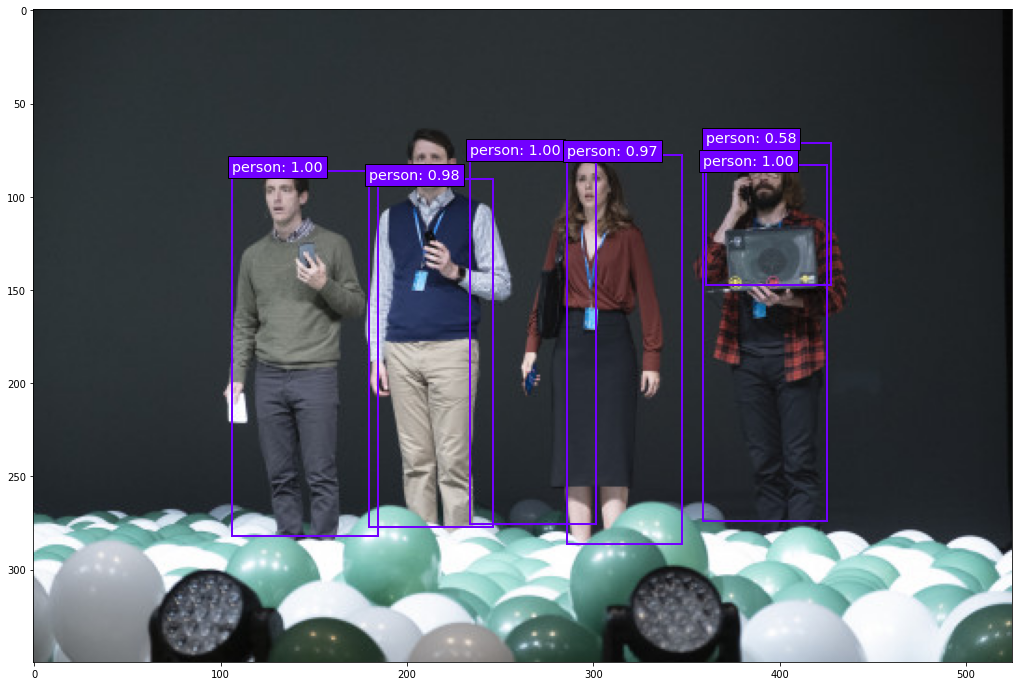

In [0]:
from matplotlib import pyplot as plt

# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_decoded[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

# 3) Inference using the tflite model

In [0]:
import tensorflow as tf
import numpy as np
import time

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

#Inference
interpreter.set_tensor(input_details[0]['index'], input_images)
interpreter.invoke()

#0=cls, 1=reg, 2=base_layers
y_pred = interpreter.get_tensor(output_details[0]['index'])

In [0]:
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=True,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded)

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[array([[ 15.  ,   1.  , 133.75,  65.93, 172.31, 236.39],
       [ 15.  ,   1.  ,  60.8 ,  73.95, 105.4 , 241.73],
       [ 15.  ,   1.  , 205.01,  71.16, 243.24, 234.91],
       [ 15.  ,   0.98, 102.73,  77.6 , 140.66, 237.5 ],
       [ 15.  ,   0.97, 163.52,  66.46, 198.49, 245.39],
       [ 15.  ,   0.58, 205.86,  60.81, 244.38, 126.45]])]


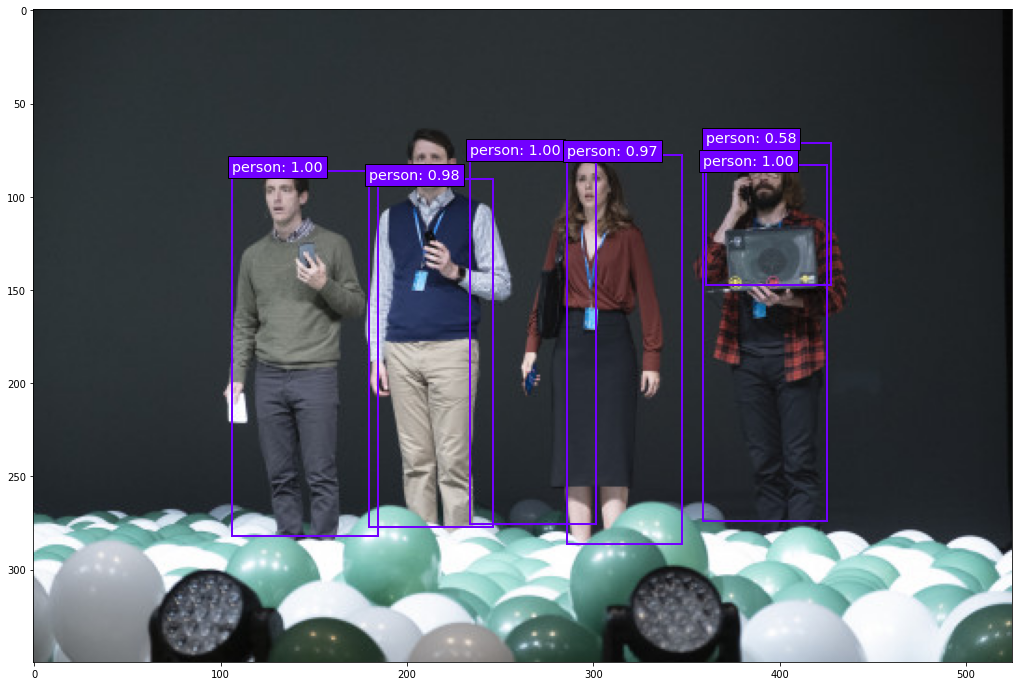

In [0]:
from matplotlib import pyplot as plt

# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_decoded[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})